In [2]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
from dotenv import load_dotenv
import json

load_dotenv()

model = ChatGroq(
    model="llama-3.1-8b-instant"
)

response = model.invoke("Give me a joke about cats")
response

AIMessage(content='Why did the cat join a band? \n\nBecause it wanted to be the purr-cussionist.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 41, 'total_tokens': 63, 'completion_time': 0.019427339, 'completion_tokens_details': None, 'prompt_time': 0.002030871, 'prompt_tokens_details': None, 'queue_time': 0.044744679, 'total_time': 0.02145821}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c6056-b30a-7983-903e-3da99124d916-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 41, 'output_tokens': 22, 'total_tokens': 63})

In [3]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]

memory = MemorySaver()

C:\Users\monuj\AppData\Local\Temp\ipykernel_18340\3363489544.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


In [4]:
llm_with_tools = model.bind_tools(tools=tools)

In [5]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result],
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tools_node"
    else:
        return END
    
async def tools_node(state: State):
    tool_calls = state["messages"][-1].tool_calls
    tool_messages = []

    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name == "tavily_search_results_json":
            search_results = await search_tool.ainvoke(tool_args)

            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )

            tool_messages.append(tool_message)

    # ✅ return must be inside function, but outside loop
    return {"messages": tool_messages}


graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tools_node", tools_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tools_node", "model")

graph = graph_builder.compile(checkpointer=memory)

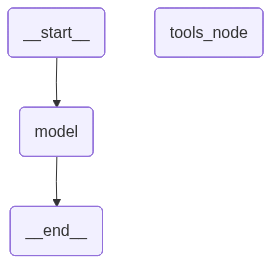

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [ ]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next solar eclipse?")],
}, config=config)

response

In [20]:
config = {
    "configurable": {
        "thread_id": 7
    }
}

async for event in  graph.astream_events({
    "messages": [HumanMessage(content="Give me a 100 word essay about the history of the internet")],
}, config=config, version="v2"):

    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

The history of the internet is a story of rapid evolution and growth. The first network, ARPANET, was created in 1969 by the US Department of Defense as a way to connect computers at different research institutions. In the 1980s, the Internet Protocol (IP) was developed, allowing different networks to communicate with each other. The World Wide Web (WWW) was born in 1989 with the creation of HTTP, HTML, and URL. The internet was made available to the public in the 1990s, revolutionizing the way people communicate, access information, and conduct business. It has since become a global phenomenon.